## Preliminaries

In [1]:
from lemonade.traj.trajectory import LatticeTraj
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
def get_domain_and_motif_positions(frame, Nb_valency, CoA_arch, TAD_arch):
    A_positions = []
    B_positions = []
    M_positions = []
    N_positions = []
    
    n_polymers = len(frame)
    M_motif_seq_pos = TAD_arch.find('M')
    N_motif_seq_pos = TAD_arch.find('N')
    A_dom_seq_pos = CoA_arch.find('A')
    B_dom_seq_pos = CoA_arch.find('B')

    if Nb_valency == 'Nb':
        n_CoA = n_polymers - 300

        if M_motif_seq_pos != -1 and N_motif_seq_pos != -1:
            for p in range(201,301):
                chain = frame[p]
                M_positions.append(chain.positions[M_motif_seq_pos])
                N_positions.append(chain.positions[N_motif_seq_pos])
        elif M_motif_seq_pos != -1 and N_motif_seq_pos == -1:
            for p in range(201,301):
                chain = frame[p]
                #print(p, chain, chain.sequence)
                M_positions.append(chain.positions[M_motif_seq_pos])
        elif M_motif_seq_pos == -1 and N_motif_seq_pos != -1:
            for p in range(201,301):
                chain = frame[p]
                N_positions.append(chain.positions[N_motif_seq_pos])
        else:
            pass
    
    else:
        raise Exception('Invalid Nb valency')


    # CoA
    if A_dom_seq_pos != -1 and B_dom_seq_pos != -1:
        for p in range(n_polymers-n_CoA+1, n_polymers+1):
            chain = frame[p]
            A_positions.append(chain.positions[A_dom_seq_pos])
            B_positions.append(chain.positions[B_dom_seq_pos])
    elif A_dom_seq_pos != -1 and B_dom_seq_pos == -1:
        for p in range(n_polymers-n_CoA+1, n_polymers+1):
            chain = frame[p]
            A_positions.append(chain.positions[A_dom_seq_pos])
    elif A_dom_seq_pos == -1 and B_dom_seq_pos != -1:
        for p in range(n_polymers-n_CoA+1, n_polymers+1):
            chain = frame[p]
            B_positions.append(chain.positions[B_dom_seq_pos])

    return np.array(A_positions), np.array(B_positions), np.array(M_positions), np.array(N_positions)



def get_Ab_microstates(positions_dict, Nb_valency, CoA_arch, TAD_arch):
    total_Ab = 100
    Ab_interactions = {}
    for Ab_idx in range(total_Ab):
        Ab_interactions[Ab_idx] = []
    
    if Nb_valency == 'Nb':
        if 'M' in TAD_arch:
            m = positions_dict['M']
            for i in range(len(m)):  # Should be 100
                if 'A' in CoA_arch:
                    Ab_interactions[i].extend(find_identical_rows(positions_dict['A'], get_adjacent_points(m[i])))
                if 'B' in CoA_arch:
                    Ab_interactions[i].extend(find_identical_rows(positions_dict['B'], get_adjacent_points(m[i])))
        if 'N' in TAD_arch:
            n = positions_dict['N']
            for i in range(len(n)):  # Should be 100
                if 'A' in CoA_arch:
                    Ab_interactions[i].extend(find_identical_rows(positions_dict['A'], get_adjacent_points(n[i])))
                if 'B' in CoA_arch:
                    Ab_interactions[i].extend(find_identical_rows(positions_dict['B'], get_adjacent_points(n[i])))     

    else:
        return None

    microstate_fractions = {'unbound':0, 'bound1CoA':0, 'bound2CoA':0, 
                            'bound3CoA':0, 'bound4CoA':0, 'bound5+CoA':0}

    for Ab_idx, interactions in Ab_interactions.items():
        n_ints = len(set(interactions))
        if n_ints == 0:
            microstate_fractions['unbound'] += 1
        elif n_ints == 1:
            microstate_fractions['bound1CoA'] += 1
        elif n_ints == 2:
            microstate_fractions['bound2CoA'] += 1
        elif n_ints == 3:
            microstate_fractions['bound3CoA'] += 1
        elif n_ints == 4:
            microstate_fractions['bound4CoA'] += 1
        else:
            microstate_fractions['bound5+CoA'] += 1

    for state in microstate_fractions:
        microstate_fractions[state] /= 100

    return microstate_fractions


def get_CoA_microstates(positions_dict, Nb_valency, CoA_arch, TAD_arch, n_CoA):
    total_Ab = 100

    CoA_interactions = {}
    for CoA_idx in range(n_CoA):
        CoA_interactions[CoA_idx] = []

    if 'A' in CoA_arch:
        a = positions_dict['A']
        for i in range(n_CoA):
            if 'M' in TAD_arch:
                CoA_interactions[i].extend(find_identical_rows(positions_dict['M'], get_adjacent_points(a[i])))
            if 'N' in TAD_arch:
                CoA_interactions[i].extend(find_identical_rows(positions_dict['N'], get_adjacent_points(a[i])))
    if 'B' in CoA_arch:
        b = positions_dict['B']
        for i in range(n_CoA):
            if 'M' in TAD_arch:
                CoA_interactions[i].extend(find_identical_rows(positions_dict['M'], get_adjacent_points(b[i])))
            if 'N' in TAD_arch:
                CoA_interactions[i].extend(find_identical_rows(positions_dict['N'], get_adjacent_points(b[i])))

    microstate_fractions = {'unbound':0, 'bound1AD':0, 'bound2_sameAD':0, 
                            'bound2_sameAb':0, 'bound2_diffAb':0, 'other':0}

    if Nb_valency == 'Nb':
        for CoA_idx, interactions in CoA_interactions.items():
            n_ints = len(interactions)
            unique_ints = list(set(interactions))
            n_unique_ints = len(unique_ints)
            if n_ints == 0:
                microstate_fractions['unbound'] += 1
            elif n_ints == 1:
                microstate_fractions['bound1AD'] += 1
            elif n_ints == 2:
                if n_unique_ints == 1:
                    microstate_fractions['bound2_sameAD'] += 1
                else:
                    microstate_fractions['bound2_diffAb'] += 1
            else:
                if n_unique_ints == 1:
                    microstate_fractions['bound2_sameAD'] += 1
                else:
                    print(interactions)
                    microstate_fractions['other'] += 1
    
    else:
        return None

    for state in microstate_fractions:
        microstate_fractions[state] /= n_CoA

    return microstate_fractions


def get_adjacent_points(point):
# Define offsets for adjacent points including diagonals
    offsets = np.array([[1, 0, 0], [-1, 0, 0],
                        [0, 1, 0], [0, -1, 0],
                        [0, 0, 1], [0, 0, -1],
                        [1, 1, 0], [-1, -1, 0],
                        [1, 0, 1], [-1, 0, -1],
                        [0, 1, 1], [0, -1, -1],
                        [1, 1, 1], [-1, -1, -1],
                        [1, -1, 0], [-1, 1, 0],
                        [1, 0, -1], [-1, 0, 1],
                        [0, 1, -1], [0, -1, 1],
                        [-1, 1, 1], [1, -1, -1],
                        [-1, -1, 1], [1, 1, -1]])
    
    return point + offsets


def check_array_presence(arr, target_arr):
    # Check if any row in arr matches the target_arr
    presence_check = np.any(np.all(arr == target_arr, axis=1))
    return presence_check


def find_identical_rows(arr1, arr2):
    """
    Find rows of an Mx3 array that are identical to any rows in an Nx3 array.
    
    Parameters:
    - arr1: Mx3 numpy array
    - arr2: Nx3 numpy array
    
    Returns:
    - List of indices of rows in arr1 that are identical to rows in arr2
    """
    # Reshape arrays to ensure they have the same number of dimensions
    arr1_reshaped = arr1.reshape(-1, arr1.shape[-1])
    arr2_reshaped = arr2.reshape(-1, arr2.shape[-1])
    
    # Find indices of rows in arr1 that are identical to rows in arr2
    identical_rows_indices = np.where(np.all(arr1_reshaped[:, None, :] == arr2_reshaped, axis=-1).any(axis=1))[0]
    return identical_rows_indices.tolist()

In [4]:
root = Path('/work/degriffith/pimms/fordyce_collab/multichain_sims/fixed_surface_set4_affinity_titration') 
valencies = ['Nb']
int_energies = [-1, -110, -160, -210]
CoA_concentrations = [5, 10, 20, 40, 80, 160, 250, 500, 1000, 2000, 4000]
test_CoA_concentrations = [20, 160, 500, 1000, 2000]
reps = [1, 2, 3]

singleTAD_arch = 'FGGGMGG'
doubleTAD_arch = 'FGGGMGGGGNGG'
singleCoA_arch = 'SSASS'
doubleCoA_arch = 'ASSSSSSSSSSSSSSSSB'

systems = {
            'singleTAD_singleCoA':{'TAD_arch':singleTAD_arch, 'CoA_arch':singleCoA_arch}, 
            'singleTAD_doubleCoA':{'TAD_arch':singleTAD_arch, 'CoA_arch':doubleCoA_arch},
            'doubleTAD_singleCoA':{'TAD_arch':doubleTAD_arch, 'CoA_arch':singleCoA_arch},
            'doubleTAD_doubleCoA':{'TAD_arch':doubleTAD_arch, 'CoA_arch':doubleCoA_arch},
          }

## Example

In [6]:
example_dir = root / 'doubleTAD_doubleCoA' / 'Nb' / f'AM_-210' / f'BM_-210' / f'AN_-210' / f'BN_-210' / str(1000) / str(2)
pdb = example_dir / 'START.pdb'
xtc = example_dir / 'traj.xtc'
key = example_dir / 'KEYFILE.kf'

In [12]:
traj = LatticeTraj(xtcfile=xtc, pdbfile=pdb, keyfile=key, verbose=True, start=200, increment=3)

for i, frame in enumerate(traj):
    a,b,m,n = get_domain_and_motif_positions(frame, 'Nb', doubleCoA_arch, doubleTAD_arch)

Reading in /work/degriffith/pimms/fordyce_collab/multichain_sims/fixed_surface_set4_affinity_titration/doubleTAD_doubleCoA/Nb/AM_-210/BM_-210/AN_-210/BN_-210/1000/2/traj.xtc now...done!
Slicing as traj[200:501:3] - followed by framecount selection: yeilds a trajectory with 101 frames
Found EXTRA_CHAIN keyword

Parsing in CHAIN : 100 Q
Parsing in CHAIN : 100 IYYW
Parsing in CHAIN : 0 LYYW
Parsing in CHAIN : 100 FGGGMGGGGNGG
Parsing in CHAIN : 0 FGGGMGGGGNGG
Parsing in EXTRA_CHAIN : 1000 ASSSSSSSSSSSSSSSSB

Finished parsing all chains
Building new lattice trajectory...
Done!


## Single TAD x Single CoA

In [50]:
all_Nb_state_data = []
all_CoA_state_data = []

syst = 'singleTAD_singleCoA'
print(syst)
TAD_arch = systems[syst]['TAD_arch']
CoA_arch = systems[syst]['CoA_arch']

# AM BM AN BN
for AM_int in int_energies:
    print('  AM ', AM_int)

    for coa_total in test_CoA_concentrations:
        for r in reps:
            directory = root / syst / 'Nb' / f'AM_{AM_int}' / str(coa_total) / str(r)
            pdb = directory / 'START.pdb'
            xtc = directory / 'traj.xtc'
            key = directory / 'KEYFILE.kf'

            traj = LatticeTraj(xtcfile=xtc, pdbfile=pdb, keyfile=key, verbose=False, start=200, increment=3)

            Nb_state_data = []
            CoA_state_data = []
            for frame in traj[::2]:
                a,b,m,n = get_domain_and_motif_positions(frame, 'Nb', CoA_arch, TAD_arch)
                pos_dict = {'A':a, 'B':b, 'M':m, 'N':n}
                
                Nb_microstates = get_Ab_microstates(pos_dict, 'Nb', CoA_arch, TAD_arch)
                Nb_state_data.append(Nb_microstates)

                CoA_microstates = get_CoA_microstates(pos_dict, 'Nb', CoA_arch, TAD_arch, coa_total)
                CoA_state_data.append(CoA_microstates)

            Nb_df = pd.DataFrame(Nb_state_data).mean()
            Nb_df['valency'] = 'Nb'
            Nb_df['system'] = syst
            Nb_df['CoA_conc'] = coa_total
            Nb_df['rep'] = r
            Nb_df['AM_int'] = AM_int
            all_Nb_state_data.append(Nb_df)

            CoA_df = pd.DataFrame(CoA_state_data).mean()
            CoA_df['valency'] = 'Nb'
            CoA_df['system'] = syst
            CoA_df['CoA_conc'] = coa_total
            CoA_df['rep'] = r
            CoA_df['AM_int'] = AM_int
            all_CoA_state_data.append(CoA_df)  

AD_state_df = pd.DataFrame(all_Nb_state_data)
CoA_state_df = pd.DataFrame(all_CoA_state_data)

AD_state_df['energies'] = AD_state_df.apply(lambda x: 'AM' + str(x['AM_int']), axis=1)
CoA_state_df['energies'] = CoA_state_df.apply(lambda x: 'AM' + str(x['AM_int']), axis=1)

singleTAD_singleCoA
  AM  -1


Exception: The xtcfile passed [/work/degriffith/pimms/fordyce_collab/multichain_sims/fixed_surface_set4_affinity_titration/singleTAD_singleCoA/Nb/AM_-1/BM_-210/20/1/traj.xtc] was not found

In [45]:
CoA_state_df.groupby(by=['energies', 'CoA_conc', 'valency', 'system']).mean().to_csv('set4_singleTAD_singleCoA_CoA_microstates.csv')
AD_state_df.groupby(by=['energies', 'CoA_conc', 'valency', 'system']).mean().to_csv('set4_singleTAD_singleCoA_TAD_microstates.csv')

## Single TAD x Double CoA

In [52]:
all_Nb_state_data = []
all_CoA_state_data = []

syst = 'singleTAD_doubleCoA'
print(syst)
TAD_arch = systems[syst]['TAD_arch']
CoA_arch = systems[syst]['CoA_arch']

# AM BM AN BN
for AM_int in int_energies:
    print(' AM ', AM_int)
    for BM_int in int_energies:
        print('   BM ', BM_int)
        for coa_total in test_CoA_concentrations:
            for r in reps:
                directory = root / syst / 'Nb' / f'AM_{AM_int}' / f'BM_{BM_int}' / str(coa_total) / str(r)
                pdb = directory / 'START.pdb'
                xtc = directory / 'traj.xtc'
                key = directory / 'KEYFILE.kf'

                if pdb.is_file() and xtc.is_file() and key.is_file():
                    traj = LatticeTraj(xtcfile=xtc, pdbfile=pdb, keyfile=key, verbose=False, start=200, increment=3)
        
                    Nb_state_data = []
                    CoA_state_data = []
                    for frame in traj[::2]:
                        a,b,m,n = get_domain_and_motif_positions(frame, 'Nb', CoA_arch, TAD_arch)
                        pos_dict = {'A':a, 'B':b, 'M':m, 'N':n}
                        
                        Nb_microstates = get_Ab_microstates(pos_dict, 'Nb', CoA_arch, TAD_arch)
                        Nb_state_data.append(Nb_microstates)
        
                        CoA_microstates = get_CoA_microstates(pos_dict, 'Nb', CoA_arch, TAD_arch, coa_total)
                        CoA_state_data.append(CoA_microstates)
        
                    Nb_df = pd.DataFrame(Nb_state_data).mean()
                    Nb_df['valency'] = 'Nb'
                    Nb_df['system'] = syst
                    Nb_df['CoA_conc'] = coa_total
                    Nb_df['rep'] = r
                    Nb_df['AM_int'] = AM_int
                    Nb_df['BM_int'] = BM_int
                    all_Nb_state_data.append(Nb_df)
        
                    CoA_df = pd.DataFrame(CoA_state_data).mean()
                    CoA_df['valency'] = 'Nb'
                    CoA_df['system'] = syst
                    CoA_df['CoA_conc'] = coa_total
                    CoA_df['rep'] = r
                    CoA_df['AM_int'] = AM_int
                    CoA_df['BM_int'] = BM_int
                    all_CoA_state_data.append(CoA_df)  

AD_state_df = pd.DataFrame(all_Nb_state_data)
CoA_state_df = pd.DataFrame(all_CoA_state_data)

AD_state_df['energies'] = AD_state_df.apply(lambda x: 'AM' + str(x['AM_int']) + '_BM' + str(x['BM_int']), axis=1)
CoA_state_df['energies'] = CoA_state_df.apply(lambda x: 'AM' + str(x['AM_int']) + '_BM' + str(x['BM_int']), axis=1)

singleTAD_doubleCoA
 AM  -1
   BM  -1
   BM  -110
   BM  -160
   BM  -210
 AM  -110
   BM  -1
   BM  -110
   BM  -160
   BM  -210
 AM  -160
   BM  -1
   BM  -110
   BM  -160
   BM  -210
 AM  -210
   BM  -1
   BM  -110
   BM  -160
   BM  -210


In [53]:
CoA_state_df.groupby(by=['energies', 'CoA_conc', 'valency', 'system']).mean().to_csv('set4_singleTAD_doubleCoA_CoA_microstates.csv')
AD_state_df.groupby(by=['energies', 'CoA_conc', 'valency', 'system']).mean().to_csv('set4_singleTAD_doubleCoA_TAD_microstates.csv')

## Double TAD x Single CoA

In [54]:
all_Nb_state_data = []
all_CoA_state_data = []

syst = 'doubleTAD_singleCoA'
print(syst)
TAD_arch = systems[syst]['TAD_arch']
CoA_arch = systems[syst]['CoA_arch']

# AM BM AN BN
for AM_int in int_energies:
    print(' AM ', AM_int)
    for AN_int in int_energies:
        print('   AN ', AN_int)
        for coa_total in test_CoA_concentrations:
            for r in reps:
                directory = root / syst / 'Nb' / f'AM_{AM_int}' / f'AN_{AN_int}' / str(coa_total) / str(r)
                pdb = directory / 'START.pdb'
                xtc = directory / 'traj.xtc'
                key = directory / 'KEYFILE.kf'

                if pdb.is_file() and xtc.is_file() and key.is_file():
                    traj = LatticeTraj(xtcfile=xtc, pdbfile=pdb, keyfile=key, verbose=False, start=200, increment=3)
        
                    Nb_state_data = []
                    CoA_state_data = []
                    for frame in traj[::2]:
                        a,b,m,n = get_domain_and_motif_positions(frame, 'Nb', CoA_arch, TAD_arch)
                        pos_dict = {'A':a, 'B':b, 'M':m, 'N':n}
                        
                        Nb_microstates = get_Ab_microstates(pos_dict, 'Nb', CoA_arch, TAD_arch)
                        Nb_state_data.append(Nb_microstates)
        
                        CoA_microstates = get_CoA_microstates(pos_dict, 'Nb', CoA_arch, TAD_arch, coa_total)
                        CoA_state_data.append(CoA_microstates)
        
                    Nb_df = pd.DataFrame(Nb_state_data).mean()
                    Nb_df['valency'] = 'Nb'
                    Nb_df['system'] = syst
                    Nb_df['CoA_conc'] = coa_total
                    Nb_df['rep'] = r
                    Nb_df['AM_int'] = AM_int
                    Nb_df['AN_int'] = _int
                    all_Nb_state_data.append(Nb_df)
        
                    CoA_df = pd.DataFrame(CoA_state_data).mean()
                    CoA_df['valency'] = 'Nb'
                    CoA_df['system'] = syst
                    CoA_df['CoA_conc'] = coa_total
                    CoA_df['rep'] = r
                    CoA_df['AM_int'] = AM_int
                    CoA_df['AN_int'] = AN_int
                    all_CoA_state_data.append(CoA_df)  

AD_state_df = pd.DataFrame(all_Nb_state_data)
CoA_state_df = pd.DataFrame(all_CoA_state_data)

AD_state_df['energies'] = AD_state_df.apply(lambda x: 'AM' + str(x['AM_int']) + '_AN' + str(x['AN_int']), axis=1)
CoA_state_df['energies'] = CoA_state_df.apply(lambda x: 'AM' + str(x['AM_int']) + '_AN' + str(x['AN_int']), axis=1)

doubleTAD_singleCoA
 AM  -1
   AN  -1
   AN  -110
   AN  -160
   AN  -210
 AM  -110
   AN  -1
   AN  -110
   AN  -160
   AN  -210
 AM  -160
   AN  -1
   AN  -110
   AN  -160
   AN  -210
 AM  -210
   AN  -1
   AN  -110
   AN  -160
   AN  -210


In [55]:
CoA_state_df.groupby(by=['energies', 'CoA_conc', 'valency', 'system']).mean().to_csv('set4_doubleTAD_singleCoA_CoA_microstates.csv')
AD_state_df.groupby(by=['energies', 'CoA_conc', 'valency', 'system']).mean().to_csv('set4_doubleTAD_singleCoA_TAD_microstates.csv')

## Double TAD x Double CoA

In [5]:
all_Nb_state_data = []
all_CoA_state_data = []

syst = 'doubleTAD_doubleCoA'
print(syst)
TAD_arch = systems[syst]['TAD_arch']
CoA_arch = systems[syst]['CoA_arch']

# AM BM AN BN
for AM_int in int_energies:
    print(' AM ', AM_int)
    for BM_int in int_energies:
        print('   BM ', BM_int)
        for AN_int in int_energies:
            print('     AN ', AN_int)
            for BN_int in int_energies:
                print('       BN ', BN_int)
                for coa_total in test_CoA_concentrations:
                    for r in reps:
                        directory = root / syst / 'Nb' / f'AM_{AM_int}' / f'BM_{BM_int}' / f'AN_{AN_int}' / f'BN_{BN_int}' / str(coa_total) / str(r)
                        pdb = directory / 'START.pdb'
                        xtc = directory / 'traj.xtc'
                        key = directory / 'KEYFILE.kf'
        
                        if pdb.is_file() and xtc.is_file() and key.is_file():
                            traj = LatticeTraj(xtcfile=xtc, pdbfile=pdb, keyfile=key, verbose=False, start=200, increment=3)
                
                            Nb_state_data = []
                            CoA_state_data = []
                            for frame in traj[::2]:
                                a,b,m,n = get_domain_and_motif_positions(frame, 'Nb', CoA_arch, TAD_arch)
                                pos_dict = {'A':a, 'B':b, 'M':m, 'N':n}
                                
                                Nb_microstates = get_Ab_microstates(pos_dict, 'Nb', CoA_arch, TAD_arch)
                                Nb_state_data.append(Nb_microstates)
                
                                CoA_microstates = get_CoA_microstates(pos_dict, 'Nb', CoA_arch, TAD_arch, coa_total)
                                CoA_state_data.append(CoA_microstates)
                
                            Nb_df = pd.DataFrame(Nb_state_data).mean()
                            Nb_df['valency'] = 'Nb'
                            Nb_df['system'] = syst
                            Nb_df['CoA_conc'] = coa_total
                            Nb_df['rep'] = r
                            Nb_df['AM_int'] = AM_int
                            Nb_df['AN_int'] = AN_int
                            Nb_df['BM_int'] = BM_int
                            Nb_df['BN_int'] = BN_int
                            all_Nb_state_data.append(Nb_df)
                
                            CoA_df = pd.DataFrame(CoA_state_data).mean()
                            CoA_df['valency'] = 'Nb'
                            CoA_df['system'] = syst
                            CoA_df['CoA_conc'] = coa_total
                            CoA_df['rep'] = r
                            CoA_df['AM_int'] = AM_int
                            CoA_df['AN_int'] = AN_int
                            CoA_df['BM_int'] = BM_int
                            CoA_df['BN_int'] = BN_int
                            all_CoA_state_data.append(CoA_df)  

AD_state_df = pd.DataFrame(all_Nb_state_data)
CoA_state_df = pd.DataFrame(all_CoA_state_data)

AD_state_df['energies'] = AD_state_df.apply(lambda x: 'AM' + str(x['AM_int']) + '_AN' + str(x['AN_int']) + '_BM' + str(x['BM_int']) + '_BN' + str(x['BN_int']), axis=1)
CoA_state_df['energies'] = CoA_state_df.apply(lambda x: 'AM' + str(x['AM_int']) + '_AN' + str(x['AN_int']) + '_BM' + str(x['BM_int']) + '_BN' + str(x['BN_int']), axis=1)

doubleTAD_doubleCoA
 AM  -1
   BM  -1
     AN  -1
       BN  -1
       BN  -110
       BN  -160
       BN  -210
     AN  -110
       BN  -1
       BN  -110
       BN  -160
       BN  -210
     AN  -160
       BN  -1
       BN  -110
       BN  -160
       BN  -210
     AN  -210
       BN  -1
       BN  -110
       BN  -160
       BN  -210
   BM  -110
     AN  -1
       BN  -1
       BN  -110
       BN  -160
       BN  -210
     AN  -110
       BN  -1
       BN  -110
       BN  -160
       BN  -210
     AN  -160
       BN  -1
       BN  -110
       BN  -160
       BN  -210
     AN  -210
       BN  -1
       BN  -110
       BN  -160
       BN  -210
   BM  -160
     AN  -1
       BN  -1
       BN  -110
       BN  -160
       BN  -210
     AN  -110
       BN  -1
       BN  -110
       BN  -160
       BN  -210
     AN  -160
       BN  -1
       BN  -110
       BN  -160
       BN  -210
     AN  -210
       BN  -1
       BN  -110
       BN  -160
       BN  -210
   BM  -210
     AN  -1
       B

In [6]:
CoA_state_df.groupby(by=['energies', 'CoA_conc', 'valency', 'system']).mean().to_csv('set4_doubleTAD_doubleCoA_CoA_microstates.csv')
AD_state_df.groupby(by=['energies', 'CoA_conc', 'valency', 'system']).mean().to_csv('set4_doubleTAD_doubleCoA_TAD_microstates.csv')

unbound  \
energies                    CoA_conc valency system                          
AM-110_AN-110_BM-110_BN-1   20       Nb      doubleTAD_doubleCoA  0.997974   
                            160      Nb      doubleTAD_doubleCoA  0.988301   
                            500      Nb      doubleTAD_doubleCoA  0.960980   
                            1000     Nb      doubleTAD_doubleCoA  0.921830   
                            2000     Nb      doubleTAD_doubleCoA  0.858758   
...                                                                    ...   
AM-210_AN-210_BM-210_BN-210 20       Nb      doubleTAD_doubleCoA  0.833399   
                            160      Nb      doubleTAD_doubleCoA  0.204118   
                            500      Nb      doubleTAD_doubleCoA  0.051961   
                            1000     Nb      doubleTAD_doubleCoA  0.028627   
                            2000     Nb      doubleTAD_doubleCoA  0.021438   

                                                                  bound1CoA  \
energies                    CoA_conc valency system                           
AM-110_AN-110_BM-110_BN-1   20       Nb      doubleTAD_doubleCoA   0.002026   
                            160      Nb      doubleTAD_doubleCoA   0.011699   
                            500      Nb      doubleTAD_doubleCoA   0.038824   
                            1000     Nb      doubleTAD_doubleCoA   0.077320   
                            2000     Nb      doubleTAD_doubleCoA   0.137647   
...                                                                     ...   
AM-210_AN-210_BM-210_BN-210 20       Nb      doubleTAD_doubleCoA   0.166601   
                            160      Nb      doubleTAD_doubleCoA   0.789608   
                            500      Nb      doubleTAD_doubleCoA   0.915229   
                            1000     Nb      doubleTAD_doubleCoA   0.899020   
                            2000     Nb      doubleTAD_doubleCoA   0.832484   

                                                                  bound2CoA  \
energies                    CoA_conc valency system                           
AM-110_AN-110_BM-110_BN-1   20       Nb      doubleTAD_doubleCoA   0.000000   
                            160      Nb      doubleTAD_doubleCoA   0.000000   
                            500      Nb      doubleTAD_doubleCoA   0.000196   
                            1000     Nb      doubleTAD_doubleCoA   0.000850   
                            2000     Nb      doubleTAD_doubleCoA   0.003529   
...                                                                     ...   
AM-210_AN-210_BM-210_BN-210 20       Nb      doubleTAD_doubleCoA   0.000000   
                            160      Nb      doubleTAD_doubleCoA   0.006275   
                            500      Nb      doubleTAD_doubleCoA   0.032810   
                            1000     Nb      doubleTAD_doubleCoA   0.072353   
                            2000     Nb      doubleTAD_doubleCoA   0.146078   

                                                                  bound3CoA  \
energies                    CoA_conc valency system                           
AM-110_AN-110_BM-110_BN-1   20       Nb      doubleTAD_doubleCoA   0.000000   
                            160      Nb      doubleTAD_doubleCoA   0.000000   
                            500      Nb      doubleTAD_doubleCoA   0.000000   
                            1000     Nb      doubleTAD_doubleCoA   0.000000   
                            2000     Nb      doubleTAD_doubleCoA   0.000065   
...                                                                     ...   
AM-210_AN-210_BM-210_BN-210 20       Nb      doubleTAD_doubleCoA   0.000000   
                            160      Nb      doubleTAD_doubleCoA   0.000000   
                            500      Nb      doubleTAD_doubleCoA   0.000000   
                            1000     Nb      doubleTAD_doubleCoA   0.000000   
                            2000     Nb      dou

## Misc.

In [48]:
pdb.is_file()

True

In [107]:


all_Ab_state_data = []
all_CoA_state_data = []

for syst in systems[:1]:
    print(syst)
    TAD_arch = systems[syst]['TAD_arch']
    CoA_arch = systems[syst]['CoA_arch']

    # AM BM AN BN

            for coa_total in CoA_concentrations:
                for r in reps:
                    directory = root / valency / AD_arch / CoA_arch / str(coa_total) / str(r)
                    pdb = directory / 'START.pdb'
                    xtc = directory / 'traj.xtc'
                    key = directory / 'KEYFILE.kf'
    
                    traj = LatticeTraj(xtcfile=xtc, pdbfile=pdb, keyfile=key, verbose=False, start=200, increment=3)

                    Ab_state_data = []
                    CoA_state_data = []
                    for frame in traj[::2]:
                        a,b,m,n = get_domain_and_motif_positions(frame, valency, CoA_seq, TAD_seq)
                        pos_dict = {'A':a, 'B':b, 'M':m, 'N':n}
                        
                        Ab_microstates = get_Ab_microstates(pos_dict, valency, CoA_seq, TAD_seq)
                        Ab_state_data.append(Ab_microstates)
    
                        CoA_microstates = get_CoA_microstates(pos_dict, valency, CoA_seq, TAD_seq, coa_total)
                        CoA_state_data.append(CoA_microstates)

                    Ab_df = pd.DataFrame(Ab_state_data).mean()
                    Ab_df['valency'] = valency
                    Ab_df['CoA_arch'] = CoA_arch
                    Ab_df['AD_arch'] = AD_arch
                    Ab_df['CoA_conc'] = coa_total
                    Ab_df['rep'] = r
                    all_Ab_state_data.append(Ab_df)

                    CoA_df = pd.DataFrame(CoA_state_data).mean()
                    CoA_df['valency'] = valency
                    CoA_df['CoA_arch'] = CoA_arch
                    CoA_df['AD_arch'] = AD_arch
                    CoA_df['CoA_conc'] = coa_total
                    CoA_df['rep'] = r
                    all_CoA_state_data.append(CoA_df)  

AD_state_df = pd.DataFrame(all_Ab_state_data)
CoA_state_df = pd.DataFrame(all_CoA_state_data)

Nb
  single_short
    doubleCoA
    doubleCoA_1off
    doubleCoA_2off
    singleCoA
  single_long
    doubleCoA
    doubleCoA_1off
    doubleCoA_2off
    singleCoA
  double
    doubleCoA
    doubleCoA_1off
    doubleCoA_2off
    singleCoA
  double_NTDoff
    doubleCoA
    doubleCoA_1off
    doubleCoA_2off
    singleCoA
  double_CTDoff
    doubleCoA
    doubleCoA_1off
    doubleCoA_2off
    singleCoA
  double_bothoff
    doubleCoA
    doubleCoA_1off
    doubleCoA_2off
    singleCoA
Ab
  single_short
    doubleCoA
    doubleCoA_1off
    doubleCoA_2off
    singleCoA
  single_long
    doubleCoA
    doubleCoA_1off
    doubleCoA_2off
    singleCoA
  double
    doubleCoA
    doubleCoA_1off
    doubleCoA_2off
    singleCoA
  double_NTDoff
    doubleCoA
    doubleCoA_1off
    doubleCoA_2off
    singleCoA
  double_CTDoff
    doubleCoA
    doubleCoA_1off
    doubleCoA_2off
    singleCoA
  double_bothoff
    doubleCoA
    doubleCoA_1off
    doubleCoA_2off
    singleCoA


In [115]:
mean_AD_data = []
mean_CoA_data = []

for valency in ['Nb', 'Ab']:
    for AD_arch, TAD_seq in zip(AD_architectures, AD_sequences):
        for CoA_arch, CoA_seq in zip(CoA_architectures, CoA_sequences):
            for coa_total in CoA_concentrations:
                AD_subdf = AD_state_df.query(f"valency == '{valency}' and CoA_arch == '{CoA_arch}' and AD_arch == '{AD_arch}' and CoA_conc == {coa_total}")
                CoA_subdf = CoA_state_df.query(f"valency == '{valency}' and CoA_arch == '{CoA_arch}' and AD_arch == '{AD_arch}' and CoA_conc == {coa_total}")

                ad_dict = {'valency':valency, 'CoA_arch':CoA_arch, 'AD_arch':AD_arch, 'CoA_conc':coa_total,
                           'unbound':AD_subdf['unbound'].mean(), 'bound1CoA':AD_subdf['bound1CoA'].mean(),
                           'bound2CoA':AD_subdf['bound2CoA'].mean(), 'bound3CoA':AD_subdf['bound3CoA'].mean(),
                           'bound4CoA':AD_subdf['bound4CoA'].mean(), 'bound5+CoA':AD_subdf['bound5+CoA'].mean()}
                mean_AD_data.append(ad_dict)

                coa_dict = {'valency':valency, 'CoA_arch':CoA_arch, 'AD_arch':AD_arch, 'CoA_conc':coa_total,
                            'unbound':CoA_subdf['unbound'].mean(), 'bound1AD':CoA_subdf['bound1AD'].mean(),
                            'bound2_sameAD':CoA_subdf['bound2_sameAD'].mean(), 'bound2_sameAb':CoA_subdf['bound2_sameAb'].mean(),
                            'bound2_diffAb':CoA_subdf['bound2_diffAb'].mean(), 'other':CoA_subdf['other'].mean()}
                mean_CoA_data.append(coa_dict)

mean_AD_state_df = pd.DataFrame(mean_AD_data)
mean_CoA_state_df = pd.DataFrame(mean_CoA_data)

In [116]:
mean_AD_state_df

,valency,CoA_arch,AD_arch,CoA_conc,unbound,bound1CoA,bound2CoA,bound3CoA,bound4CoA,bound5+CoA
0,Nb,doubleCoA,single_short,5,0.998301,0.001699,0.0,0.0,0.0,0.0
1,Nb,doubleCoA,single_short,10,0.996078,0.003922,0.0,0.0,0.0,0.0
2,Nb,doubleCoA,single_short,20,0.992680,0.007320,0.0,0.0,0.0,0.0
3,Nb,doubleCoA,single_short,40,0.986732,0.013268,0.0,0.0,0.0,0.0
4,Nb,doubleCoA,single_short,80,0.971242,0.028758,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
523,Ab,singleCoA,double_bothoff,250,1.000000,0.000000,0.0,0.0,0.0,0.0
524,Ab,singleCoA,double_bothoff,500,1.000000,0.000000,0.0,0.0,0.0,0.0
525,Ab,singleCoA,double_bothoff,1000,1.000000,0.000000,0.0,0.0,0.0,0.0
526,Ab,singleCoA,double_bothoff,2000,1.000000,0.000000,0.0,0.0,0.0,0.0


In [117]:
mean_CoA_state_df

,valency,CoA_arch,AD_arch,CoA_conc,unbound,bound1AD,bound2_sameAD,bound2_sameAb,bound2_diffAb,other
0,Nb,doubleCoA,single_short,5,0.966013,0.033987,0.000000,0.0,0.0,0.0
1,Nb,doubleCoA,single_short,10,0.960784,0.039216,0.000000,0.0,0.0,0.0
2,Nb,doubleCoA,single_short,20,0.963399,0.035948,0.000654,0.0,0.0,0.0
3,Nb,doubleCoA,single_short,40,0.966830,0.033170,0.000000,0.0,0.0,0.0
4,Nb,doubleCoA,single_short,80,0.964052,0.035948,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
523,Ab,singleCoA,double_bothoff,250,1.000000,0.000000,0.000000,0.0,0.0,0.0
524,Ab,singleCoA,double_bothoff,500,1.000000,0.000000,0.000000,0.0,0.0,0.0
525,Ab,singleCoA,double_bothoff,1000,1.000000,0.000000,0.000000,0.0,0.0,0.0
526,Ab,singleCoA,double_bothoff,2000,1.000000,0.000000,0.000000,0.0,0.0,0.0


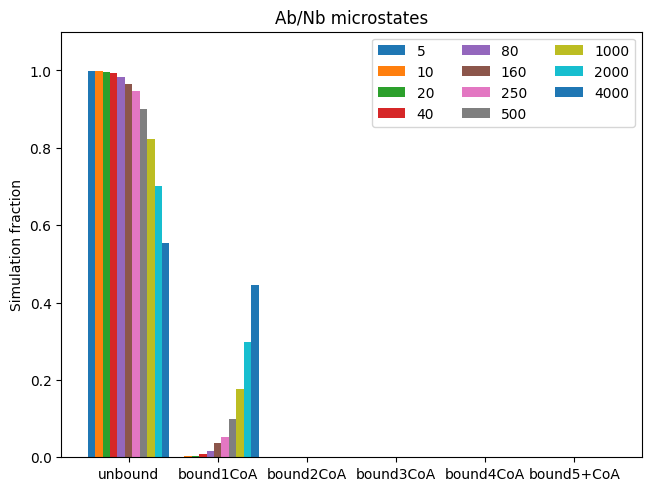

In [148]:
subdf = mean_AD_state_df.query('valency == "Nb" and CoA_arch == "singleCoA" and AD_arch == "single_short"')

plot_AD_state_bars(subdf, subdf.CoA_conc.values)

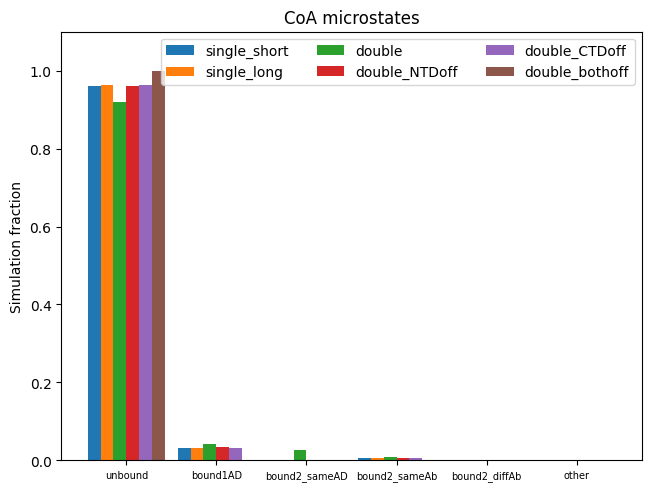

In [163]:
subdf = mean_CoA_state_df.query('valency == "Ab" and CoA_arch == "doubleCoA" and CoA_conc == 2000')

plot_CoA_state_bars(subdf, subdf.AD_arch.values)

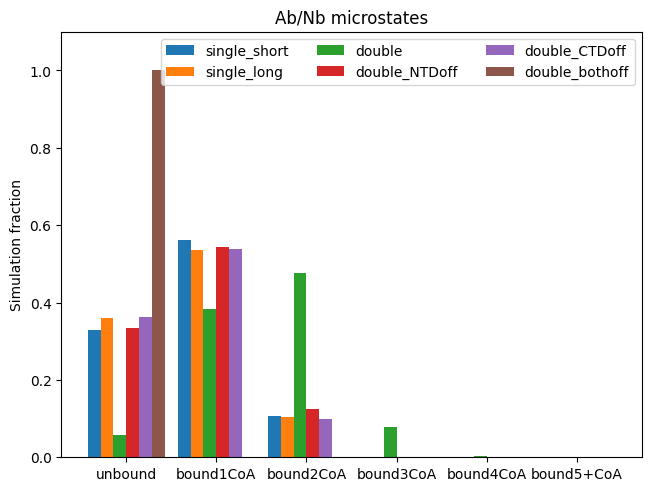

In [162]:
subdf = mean_AD_state_df.query('valency == "Ab" and CoA_arch == "doubleCoA" and CoA_conc == 2000')

plot_AD_state_bars(subdf, subdf.AD_arch.values)

In [236]:
conc = 4000
subdf = mean_AD_state_df.query(f'CoA_conc == {conc}')
CoA_architectures = ["singleCoA", "doubleCoA"]
AD_architectures = ["single_short", "double"]
macrostates = ['unbound', 'bound1CoA', 'bound2CoA', 'bound3CoA','bound4CoA']

ad_data = []
names = []
for val in ['Nb', 'Ab']:
    for ad in AD_architectures:
        for coa in CoA_architectures:
            ad_data.append(subdf.query(f"valency == '{val}' and CoA_arch == '{coa}' and AD_arch == '{ad}'").values[0, 4:].astype(float))
            names.append(f'{val}_{ad}_{coa}')
            
ad_data = np.vstack(ad_data)
ad_macrostates = np.hstack((ad_data[:,:4], ad_data[:,4:].sum(axis=1).reshape(-1,1)))

nb_macrostates = ad_macrostates[:4]
ab_macrostates = ad_macrostates[4:]

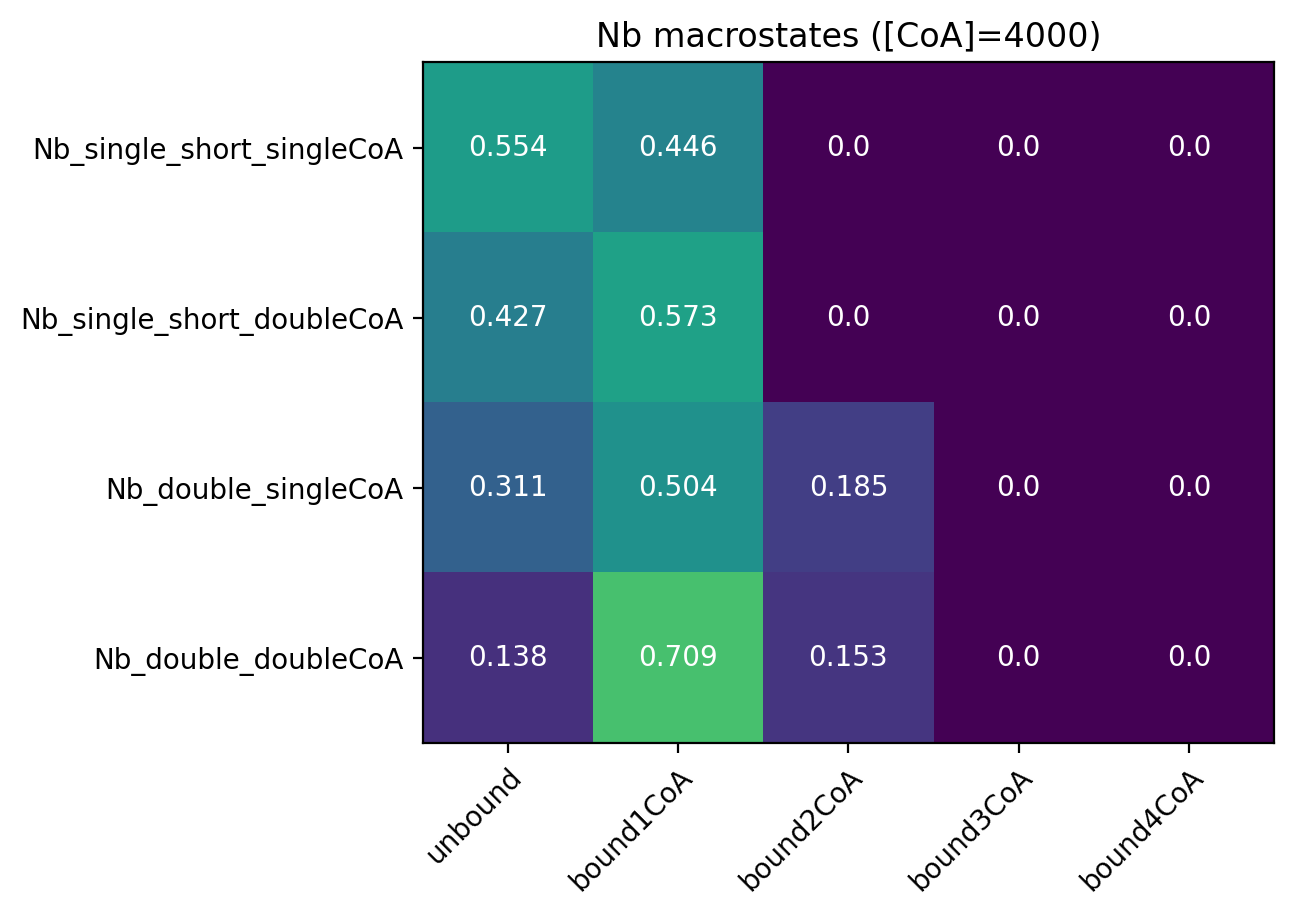

In [237]:
submatrix = nb_macrostates
name_subset = names[:4]
state_subset = macrostates

fig, ax = plt.subplots(dpi=200)
im = ax.imshow(submatrix, vmax=1)
ax.set_title(f'Nb macrostates ([CoA]={conc})')

ax.set_yticks(np.arange(len(submatrix)), labels=name_subset)
ax.set_xticks(np.arange(len(submatrix[0])), labels=state_subset)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(submatrix)):
    for j in range(len(submatrix[0])):
        text = ax.text(j, i, round(submatrix[i, j],3),
                       ha="center", va="center", color="w")

fig.tight_layout()
plt.savefig(f'Nb_macrostate_heatmap_CoA{conc}.png')
plt.show()

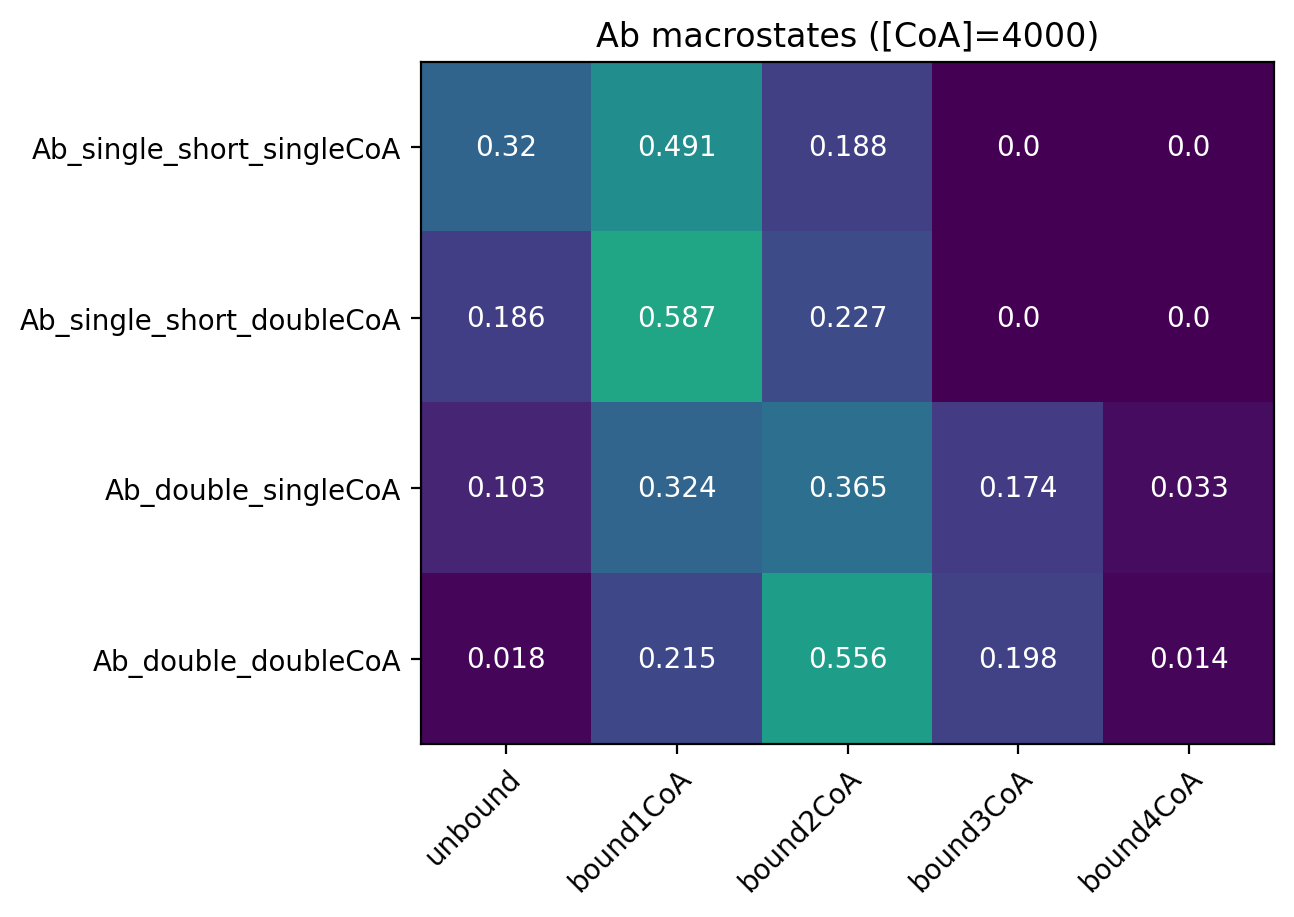

In [238]:
submatrix = ab_macrostates
name_subset = names[4:]
state_subset = macrostates

fig, ax = plt.subplots(dpi=200)
im = ax.imshow(submatrix, vmax=1)
ax.set_title(f'Ab macrostates ([CoA]={conc})')

ax.set_yticks(np.arange(len(submatrix)), labels=name_subset)
ax.set_xticks(np.arange(len(submatrix[0])), labels=state_subset)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(submatrix)):
    for j in range(len(submatrix[0])):
        text = ax.text(j, i, round(submatrix[i, j],3),
                       ha="center", va="center", color="w")

fig.tight_layout()
plt.savefig(f'Ab_macrostate_heatmap_CoA{conc}.png')
plt.show()

In [274]:
conc = 500
subdf = mean_CoA_state_df.query(f'CoA_conc == {conc}')
CoA_architectures = ["singleCoA", "doubleCoA"]
AD_architectures = ["single_short", "double"]
macrostates = ['unbound', 'bound1AD', 'bound2_sameAD', 'bound2_sameAb', 'bound2_diffAb']

coa_data = []
names = []
for val in ['Nb', 'Ab']:
    for ad in AD_architectures:
        for coa in CoA_architectures:
            coa_data.append(subdf.query(f"valency == '{val}' and CoA_arch == '{coa}' and AD_arch == '{ad}'").values[0, 4:-1].astype(float))
            names.append(f'{val}_{ad}_{coa}')
            
coa_data = np.vstack(coa_data)

nb_macrostates = coa_data[:4]
ab_macrostates = coa_data[4:]

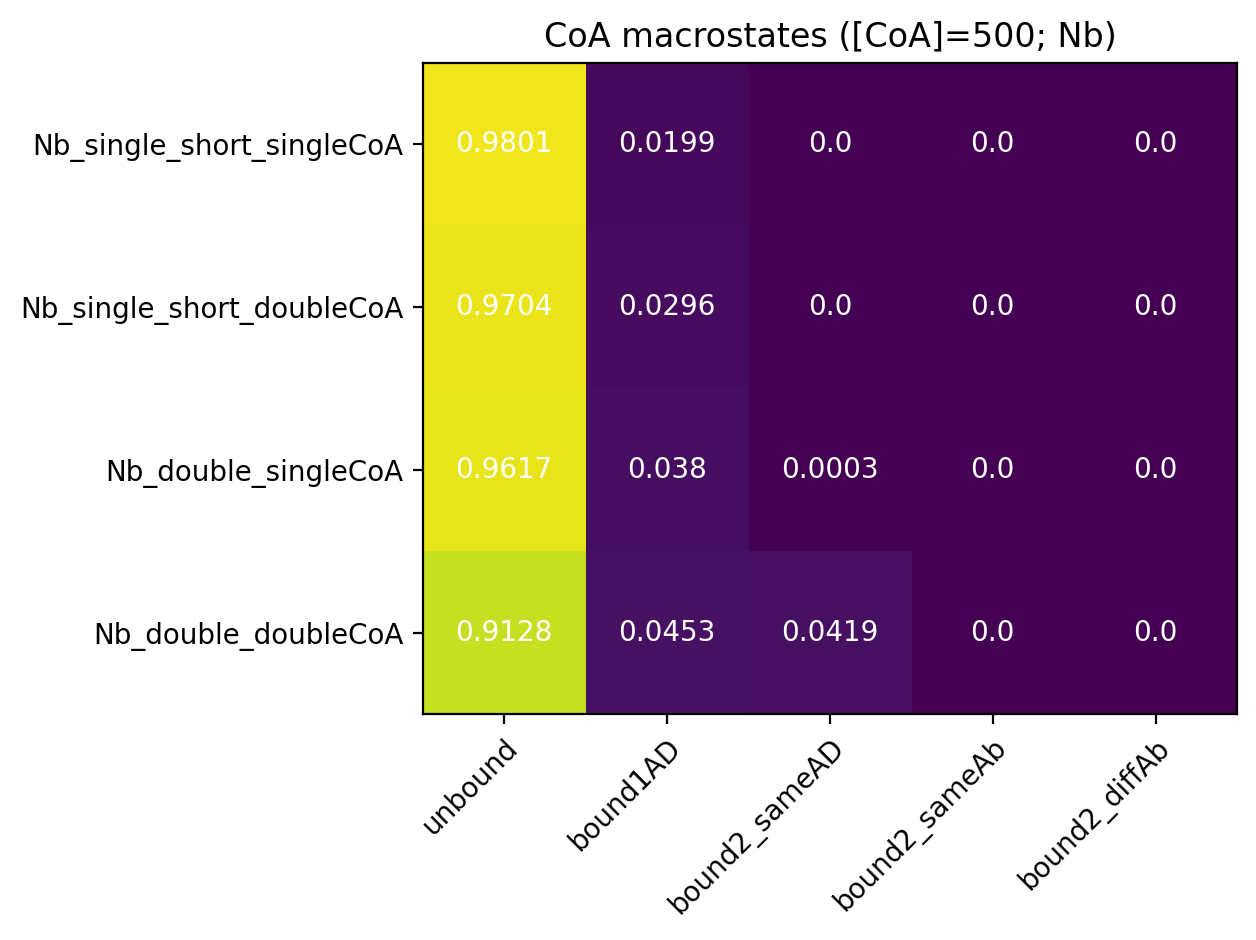

In [275]:
submatrix = nb_macrostates
name_subset = names[:4]
state_subset = macrostates

fig, ax = plt.subplots(dpi=200)
im = ax.imshow(submatrix, vmax=1)
ax.set_title(f'CoA macrostates ([CoA]={conc}; Nb)')

ax.set_yticks(np.arange(len(submatrix)), labels=name_subset)
ax.set_xticks(np.arange(len(submatrix[0])), labels=state_subset)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(submatrix)):
    for j in range(len(submatrix[0])):
        text = ax.text(j, i, round(submatrix[i, j],4),
                       ha="center", va="center", color="w")

fig.tight_layout()
plt.savefig(f'CoA_macrostate_heatmap_CoA{conc}_Nb.png')
plt.show()

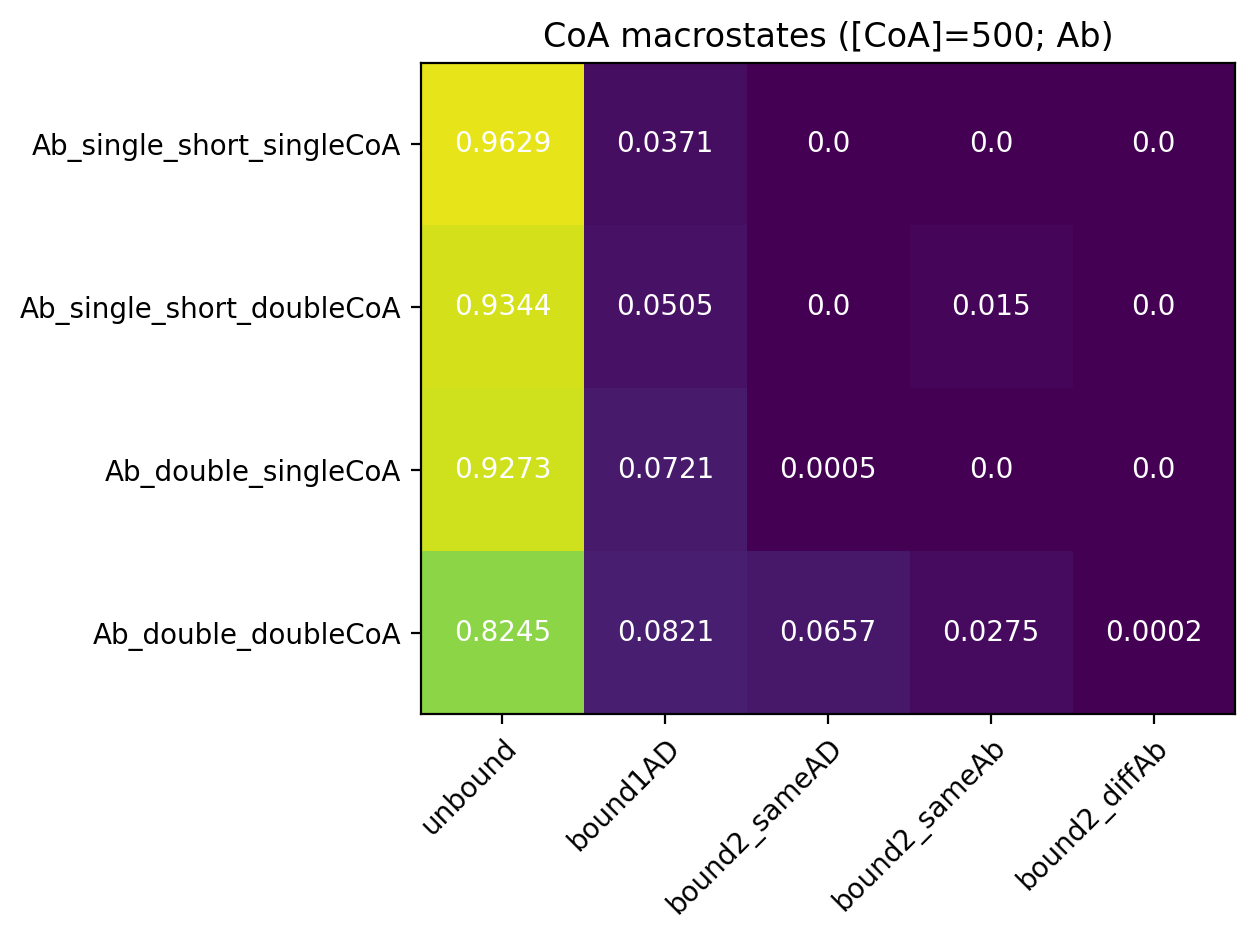

In [276]:
submatrix = ab_macrostates
name_subset = names[4:]
state_subset = macrostates

fig, ax = plt.subplots(dpi=200)
im = ax.imshow(submatrix, vmax=1)
ax.set_title(f'CoA macrostates ([CoA]={conc}; Ab)')

ax.set_yticks(np.arange(len(submatrix)), labels=name_subset)
ax.set_xticks(np.arange(len(submatrix[0])), labels=state_subset)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(submatrix)):
    for j in range(len(submatrix[0])):
        text = ax.text(j, i, round(submatrix[i, j],4),
                       ha="center", va="center", color="w")

fig.tight_layout()
plt.savefig(f'CoA_macrostate_heatmap_CoA{conc}_Ab.png')
plt.show()

In [147]:
def plot_CoA_state_bars(df, labels, title='CoA microstates'):
    groups = ('unbound', 'bound1AD', 'bound2_sameAD', 'bound2_sameAb', 'bound2_diffAb', 'other')
    means = df.values[:, 4:]

    x = np.arange(len(groups))  # the label locations
    width = 1/(len(labels)+1)  # the width of the bars

    multiplier = -len(labels)/2 + 1.5

    fig, ax = plt.subplots(layout='constrained')

    for i, mean in enumerate(means):
        offset = width * multiplier
        rects = ax.bar(x + offset, mean, width, label=labels[i])
        multiplier += 1
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Simulation fraction')
    ax.set_title(title)
    ax.set_xticks(x + width, groups, fontsize=7)
    ax.legend(ncols=3)
    ax.set_ylim(0, 1.1)
    
    plt.show()

In [146]:
def plot_AD_state_bars(df, labels, title='Ab/Nb microstates'):
    groups = ('unbound', 'bound1CoA', 'bound2CoA', 'bound3CoA', 'bound4CoA', 'bound5+CoA')
    means = df.values[:, 4:]

    x = np.arange(len(groups))  # the label locations
    width = 1/(len(labels)+1)  # the width of the bars

    multiplier = -len(labels)/2 + 1.5

    fig, ax = plt.subplots(layout='constrained')

    for i, mean in enumerate(means):
        offset = width * multiplier
        rects = ax.bar(x + offset, mean, width, label=labels[i])
        multiplier += 1
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Simulation fraction')
    ax.set_title(title)
    ax.set_xticks(x + width, groups)
    ax.legend(ncols=3)
    ax.set_ylim(0, 1.1)
    
    plt.show()

In [84]:
def get_adjacent_points(point):
# Define offsets for adjacent points including diagonals
    offsets = np.array([[1, 0, 0], [-1, 0, 0],
                        [0, 1, 0], [0, -1, 0],
                        [0, 0, 1], [0, 0, -1],
                        [1, 1, 0], [-1, -1, 0],
                        [1, 0, 1], [-1, 0, -1],
                        [0, 1, 1], [0, -1, -1],
                        [1, 1, 1], [-1, -1, -1],
                        [1, -1, 0], [-1, 1, 0],
                        [1, 0, -1], [-1, 0, 1],
                        [0, 1, -1], [0, -1, 1],
                        [-1, 1, 1], [1, -1, -1],
                        [-1, -1, 1], [1, 1, -1]])
    
    return point + offsets

def check_array_presence(arr, target_arr):
    # Check if any row in arr matches the target_arr
    presence_check = np.any(np.all(arr == target_arr, axis=1))
    return presence_check

def find_identical_rows(arr1, arr2):
    """
    Find rows of an Mx3 array that are identical to any rows in an Nx3 array.
    
    Parameters:
    - arr1: Mx3 numpy array
    - arr2: Nx3 numpy array
    
    Returns:
    - List of indices of rows in arr1 that are identical to rows in arr2
    """
    # Reshape arrays to ensure they have the same number of dimensions
    arr1_reshaped = arr1.reshape(-1, arr1.shape[-1])
    arr2_reshaped = arr2.reshape(-1, arr2.shape[-1])
    
    # Find indices of rows in arr1 that are identical to rows in arr2
    identical_rows_indices = np.where(np.all(arr1_reshaped[:, None, :] == arr2_reshaped, axis=-1).any(axis=1))[0]
    return identical_rows_indices.tolist()